**Project Description**: 
In an era where peer-to-peer financing platforms have revolutionized investment opportunities, the LendingClub stands out as a key player, allowing investors to participate in consumer loans. This project aims to leverage machine learning techniques to predict default probabilities for loans on the LendingClub platform, empowering investors to make informed decisions and optimize their returns.

**Goals**
- Develop basic understanding of risk anlytics in banking and financial sercice (credit risk accessment)
- Predict default probabilities for 2018 loans by training models on pre-2018 loan data
- Analyzes borrower's capability to repay by using machine learning and data analytics to help to reduce the default risk and therefore maximize the investment return. 


Techinqiue used here : Logistic Regression, Naive Bayes, and SVM classifiers

**Project Outline**

- [1.Import data](#section1)
- [2.Data Preprocessing](#section2)
- [3.Data Analysis](#section3)
    - [3.1] Loan amount and installment
    - [3.2] Grades, interest rate and FICO scores
    - Application Form: issue date, number of inquries last 6 months, source verified etc
    - Applicants information: work history - employment length, annual income



<!-- Feature Selection I: EDA

Feature Section II: (Linear) correlation between (numerical) features
5.1 Convert target variable to 0/1 indicator
5.2 K-S test
5.3 Pearson Correlation
Feature Engineering
6.1 Dummy variables
6.2 Train/Test data split
6.3 Imputing missing values
6.4 Feature Scaling
6.5 PCA visualization of the train data
6.6 Linear dependence of Charged-Off
Modeling
7.1 Logistic Regression with SGD
7.2 Random Forest
7.3 KNN
7.4 Hyperparameter tuning on the best model
7.5 Evaluate the best model on the testing set
Further understanding the model
Conclusion -->


In [1]:
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import sqlalchemy
import itertools
import datetime
import sys, os
from helper import *
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8')

In [2]:
####  stdout style   #####
import logging

logging.basicConfig(
    level=logging.INFO, 
    format='%(levelname)s - - - - - - - - %(message)s  - - - - - - - ',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

logger = logging.getLogger('LOGGER_NAME')

In [3]:
DATA_PATH = os.getcwd()+'/18-LendingClub/data' if 'LendingClub' not in os.getcwd() else os.getcwd()+'/data'
meta = pd.read_csv(DATA_PATH+'/LCDataDictionary.csv', index_col=['LoanStatNew'])
engine = sqlalchemy.create_engine(db_string)

# export_to_mysql(fast_load_data(p=1), 'loans')
loans = pd.read_sql('select * from loans', engine)

INFO - - - - - - - - package: mysql.connector.plugins  - - - - - - - 
INFO - - - - - - - - plugin_name: caching_sha2_password  - - - - - - - 
INFO - - - - - - - - AUTHENTICATION_PLUGIN_CLASS: MySQLCachingSHA2PasswordAuthPlugin  - - - - - - - 


### Data Preparation
<a id='section1'></a>

#### Import Data :

Data Desscription: A large data set containing about 2,9000,000 loan applications issued from 2007 to 2020Q3. These loans are categorized into two terms: 36 months and 60 months. First, we extracted a representative sample comprising 5-10% of the dataset in order to perform exploratory data analysis (EDA) and gain some insights into the data.


Randomly select 30% of the population as sample 

#### Data Information
- Source: Kaggle

- Data Size: 1.8G

- Columns : The dataset encompasses numerous columns, the majority of which pertain to backend details not accessible to investors, including information like recoveries and last payment amounts. Given our primary focus on the debt auction period, specifically when the debt is not fully funded, we can confidently exclude these backend-related details. For this purpose, a meta CSV has been generated, containing only the columns that investors have visibility into. These columns in the meta CSV provide the pertinent information available to investors during the funding period.  
- Dtypes: Check the data format dtypes


#### Check for Nulls
Pay attention to columns with many nulls, decide to keep those rows or not. 

In [ ]:
DATA_PATH = os.getcwd()+'/18-LendingClub/data' if 'LendingClub' not in os.getcwd() else os.getcwd()+'/data'
meta = pd.read_csv(DATA_PATH+'/LCDataDictionary.csv', index_col=['LoanStatNew'])

def read_csv(p):
    ''' percentage % of the lines  '''
    return pd.read_csv(DATA_PATH+'/Loan_status_2007-2020Q3.gzip', 
                     skiprows=lambda i: i>0 and random.random() > p, 
                     usecols = meta.index.to_list(),
                     date_parser = lambda s: pd.to_datetime(s, format='%b-%Y', errors='coerce'),
                     parse_dates = ['issue_d','earliest_cr_line'],
                     low_memory=False)


sample = read_csv(0.3)
logger.info ('Data sample size: %d %s'%(len(sample), ' Issue date 2007 - 2020Q3'))
sample.head(3)

In [134]:
def check_nulls(data):
    null = pd.DataFrame(data=data.isnull().sum()/len(data)*100,columns=['null_pct'])
    null = null.loc[null['null_pct']>0]
#     print (null)
    print('Columns with nulls')
    null.plot.bar(figsize=(10,2))
# check_nulls(loans)
# loans.loc[loans['mths_since_last_delinq'].isnull()].T

# names = ['emp_length', 'dti', 'mths_since_last_delinq', 'revol_util', 'chargeoff_within_12_mths', 'mort_acc', 'pub_rec_bankruptcies']

In [142]:
# loans['revol_util'].mean()
loans['mths_since_last_delinq'].mean()


34.43936233562606

In [ ]:
sample.describe()

### Pre-processing:
<a id='section2'></a>

We filter out loans that "Does not meet the credit policy" . To check if default and Charged off have the same meaning, another set of data of 2007-2018Q4 was downloaded and we extract id from loans marked as default and check the same id again in the 2007-2020Q3 (2 years later).  Because 2007-2020Q3 is so large that jupyter notebook cannot fully load the dataset, mysql is used to store and process data. 

<!-- are not yet matured and treat "Fully Paid" as 1 and "Charged Off" or "Default" as 0.  
Here, we only consider loans with those two status, as "Current" also has potentially go default in near future.  We also do not consider the loan status of ". Those are the loans issued at the early stage of the company where the system is not fully developed. -->

#### Data Cleaning
- Exclude loans labeled with the status "Does not meet the credit policy." This designation indicates a shift in the credit policy, and the loan, approved prior to this modification, does not align with the updated guidelines. 
- Convert employment length column to numeric. i.e 10 years to 10
- Convert int_rate to float
- Convert earliest_cr_line to earliest credit available year
<!-- - Conver issue_d to issue_year -->

In [ ]:
print ('sample size before cleaning: ', len(sample))
print (sample['loan_status'].value_counts(normalize=True))

In [ ]:
def clean_sample(data):
    ''' data cleaning '''
    df = data.dropna(subset=["loan_status"]).copy()    
#     df = df.loc[~df['loan_status'].str.contains('Does not meet the credit policy')]
#     df['loan_status']= df['loan_status'].str.replace('Default','Charged Off')
    df = df.loc[df['loan_status'].isin(['Charged Off', 'Fully Paid'])]
    df['fico_score'] =  (df['fico_range_high']+df['fico_range_low'])/2.0
    df['emp_length'] = df['emp_length'].replace('< 1 year','0').str.extract('(\d+)').astype(float)
    df['int_rate']   = df['int_rate'].str.rstrip('%').astype('float') / 100.0
    df['earliest_cr_line'] = df['earliest_cr_line'].dt.year
    df['issue_d'] = df['issue_d'].dt.year
    df['revol_util'] = df['revol_util'].str.strip('%').astype('float').round(1)
    df = df.drop(columns=['fico_range_high','fico_range_low','emp_title'])
    return df


loans = clean_sample(sample)

In [ ]:
def loan_status_graph(df):
    '''loan status graph''' 
    gp = convert_to_default_rate(df,'issue_d')
    status = gp.columns[0:-1]
    
    gp['Closed'] = (gp['Fully Paid']+gp['Charged Off'])/gp[status].sum(axis=1)
    display(gp)    
    loan_status = df['loan_status'].value_counts(normalize=True)
    ax = (loan_status*100).plot.bar(figsize=(6,3),color=['skyblue','salmon'])
    for p in ax.patches:
        ax.annotate('      '+str(p.get_height().round(2))+'%', (p.get_x(), p.get_height()))
    
    plt.xticks(rotation=90)
    plt.title('Loan Status (After Cleaning)')
    plt.ylabel('Percentage')    
    
loan_status_graph(loans)

In [ ]:
default_id_in_old = ['66510505' '130554933' '128147895' '127591076' '126477470' '118632698'
 '118651955' '118231939' '116813914' '113205962' '112757178' '79074327'
 '78119683' '77396993' '137067346' '111693214' '111112656' '108321482'
 '107635376' '104302191' '73450282' '24776849' '135800419' '133794246'
 '103518799' '102166209' '96826488' '124882389' '124743817' '123594775'
 '121279189' '119976809' '121839948' '120234007' '95171317' '94462584'
 '93700651' '94155408' '92272002' '91643221']

### EDA
<a id='section3'></a>

#### What could affect the default rate ? 
    - Amount borrowed or the monthly installment?
    - Debt to income ratio 
    - Grades and fico credit score (A > B > C > D > E > F)
    - Loan terms: Longer terms can increase default risk
    - How is income affecting default rate ? 
    - Has default rate increased/decreased over time ? 
    - Number of chargeoff had within the last 12 months ? 
    - Number of inquries has attempted ? 
    ... More


#### Correlation Heat Map
df.corr() compute pairwise correlation of numerical columns. The default output is the Pearson correlation coefficient. 

**Heat Map**

In the correlation heat map below the red hues implies a positive correlation, whereas blue hues indicate a negative correlation. Borrowers with elevated credit scores, higher annual income, and extended work experience demonstrate a higher likelihood of repaying loans. Conversely, there is a negative correlation with borrowed amounts, debt-to-income ratios, the number of inquiries in the last 6 months, and accounts currently delinquent. 


In [ ]:
def corr_heatmap(data):
    df = data.copy()
    col = list(df)
    col.remove('loan_status')
    col.remove('id')
    col = ['loan_status']+col
    df['loan_status'] = df['loan_status'].map(dict({'Fully Paid':1, 'Charged Off':0}))
    
    corr = df[col].corr(numeric_only=True)
    err = corr[(corr>0.8)&(corr<1)].dropna(how="all").dropna(axis="columns",how="all")
    if len(err)>0:
        logger.info('Multicollinearity Exists')
        display (err)
        
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr.round(2), cmap=cmap, vmax=0.2, vmin=-0.2, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
corr_heatmap(loans)

#### Loan amount and installment

Analyzing the box plot reveals that defaulted loans exhibit a higher loan amount or installment in average compared to fully paid ones. Hence, it can be inferred that defaults are more prevalent in cases involving larger loan amounts.

**Multicollinearity Issues**

Notice there is a strong correlation between loan_amnt and installment (r>0.9). In general, if the correlation coefficient is above 0.8, we need to drop one of them. It actually make sense because the relationship of monthly installment and loan amount is like the mortgage payment and the principal.

In [ ]:
from sklearn import preprocessing

def analysis_on_loan_amnt(df):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    fig.tight_layout(pad=5.0)
    
    # boxplot
    sns.boxplot(data=df[['loan_amnt','loan_status']], x='loan_amnt',hue='loan_status', orient="h", palette="Set2", ax=axes[0,0])
    axes[0,0].set_title('Boxplot of Loan Amount')    
    
    sns.boxplot(data=df[['installment','loan_status']], x='installment',hue='loan_status', orient="h", palette="Set2", ax=axes[0,1])
    axes[0,1].set_title('Boxplot of Installment')
    
    
    ####  Normalization    ######
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(df[['loan_amnt','installment']].values)
    scaled_df = pd.DataFrame(x_scaled,columns=['loan_amnt','installment'])
    u, v = scaled_df['loan_amnt'], scaled_df['installment']
    
    # Scatter Plot
    axes[1, 0].scatter(df['loan_amnt'], df['installment'], alpha=0.3)
    set_ax_param(axes[1,0], title='Scatter Plot', ylabel='monthly installment', xlabel='loan amount', loc=None)
    
    # Overlayed Histograms
    sns.histplot(v, kde=True, label='Installment', color='blue',bins=30, ax=axes[1,1])
    sns.histplot(u, kde=True, label='Loan Amount', color='orange', bins=30,ax=axes[1,1])
    
    set_ax_param(axes[1,1], title='Overlayed Histograms with KDE', ylabel='Frequency', xlabel='Normalized Value')
    
    plt.show()

    
logger.info('Section - Loan amount and monthly installment')    
analysis_on_loan_amnt(loans)

feature importance later ? 

#### Grades, interest rate and Fico scores
- **Grade**:  
            A, B, C, D, E, F, G.   These classifications denote various risk categories or credit grades assigned to loans, with A representing the lowest risk and G representing the highest risk. The bar charts below illustrate the loan performance within each grade. For example, Grade A exhibits a relatively lower percentage of charged-off loans compared to fully paid ones, indicating superior performance at lower risk grades. The first graph demonstrates a direct correlation between default rate and grade class. Notably, the probability of default in class G is five times higher than that of class A, but only with interest rate twice as much.  Conservative investors may consider avoiding loans in classes E, F, and G, as they often have lower repayment rates. Fortunately, the majority 75% of loans fall under the A, B, and C categories.
          
 - **Subgrade**:  
        Each grade is further divided into stratifications known as subgrades. Within each grade, there are five subgrades. For example, class A encompasses subgrades A1, A2, A3, A4, and A5, with a lower numerical value indicating a lower level of risk. Generally, the observed default rate corresponds with the subgrade trend – A1 typically exhibits a lower default rate than A2, and so forth, up to A5. However, in the domain of higher-risk loans, the accuracy of subgrade classification diminishes. Interestingly, certain subgrades in class G demonstrate a lower default rate compared to those in class F. Despite the limited instances of F and G grades, the subgrade data may not adequately represent the default patterns within these classes.
- **Interest Rate**:  
        Typically, higher interest rates signify higher risk, as investors seek greater returns for assuming increased risk. It's evident that the average interest rate is considerably higher for defaulted loans compared to fully paid ones.

- **FICO score**:  
        The majority of borrowers fall within the 650 to 750 FICO score range. Generally, borrowers with higher FICO scores demonstrate a greater likelihood of repayment, as illustrated in the graph. The default rate diminishes as FICO score increases; however, the trend begins to reverse once the FICO scores surpass 800. It's worth noting that the results may not accurately reflect the situation due to the limited sample size for borrowers with exceptionally high FICO scores.

- **Debt to income ratio**:  
            It's intuitive that individuals with higher levels of debt are less likely to repay their loans, a trend that is reflected in the graph below.


In [ ]:
def analysis_on_grade(data):
    df = data[['loan_status','term','grade','sub_grade','int_rate']].copy()

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    # -------    Grade    ----------
    status = convert_to_default_rate(df,'grade')
    status['Count'] = status[['Charged Off','Fully Paid']].sum(axis=1)
    status['Count pct'] = 100*status['Count']/len(df)
    status.plot(y='Default Rate',ax=ax[0,0], color='r', linestyle='dashed', legend=False)
    status[['Default Rate']].plot.bar(rot=0, ax=ax[0,0],alpha=1, legend=False)

    #pie chart: outer ring 
    cm = plt.get_cmap("tab20c")    
    status.plot(
        y     ='Count pct',
        kind  ='pie',
        legend=False,
        autopct=lambda v: f'{v:.1f}%', pctdistance=1.36,
        radius=1, wedgeprops=dict(width=0.3, edgecolor='w'),
        colors=cm(np.arange(3)*4),
        ax=ax[0,1]
    )
    
    # -------   Sub Grade   ----------
    status = convert_to_default_rate(df,'sub_grade')
    status['Count']     = status[['Charged Off','Fully Paid']].sum(axis=1)
    status['Count pct'] = 100*status['Count']/len(df)
    
    status.plot(y='Default Rate',ax=ax[1,0], color='r', linestyle='dashed')
    status[['Default Rate']].plot.bar(rot=90, ax=ax[1,0]) 

    status.plot.bar(y=['Charged Off', 'Fully Paid'], 
               rot=90, ax=ax[1,1], stacked=True
              ) 

    #pie chart: inner ring 
    label     = status.index.values
    label = list(label[0:20])+[' ']*(len(label)-20) 
    status.plot(
        y = 'Count pct',
        kind='pie',
        radius=0.7, wedgeprops=dict(width=0.3, edgecolor='w'),
        colors=cm([i//5*4+x for i, x in enumerate(list([0,1,2,3,3])*6)]),
        labels=label, legend=False,
        ax=ax[0,1]
    )
    
    set_ax_param(ax[0,0], ylabel='%', xlabel='Loan Grade', title='Default Rate',loc='upper left')
    set_ax_param(ax[1,0], ylabel='%', xlabel='Sub Grade',loc='upper left')
    set_ax_param(ax=ax[1,1], title='Sub Grade Distribution ', ylabel='Counts')
    ax[0,1].set_ylabel('')
    ax[0, 1].set_title('Loan Class Distribution')

   
logger.info('Section - Grade and Sub-grade')    
analysis_on_grade(loans)

In [ ]:
def analysis_on_int_rate(data,styles=['pie','boxplot'], height=4.5):
    cols=['int_rate','dti','fico_score'] 
    df = data[['loan_status']+cols].copy()
    df.loc[df['dti']>50,'dti'] = np.nan
    df['dti'] = (df['dti']//1*1).astype('Int64')
    df['int_rate'] = df['int_rate'].round(2)
    df['fico_score'] = df['fico_score'].round(0)
    
    graph = Graph_Generator(styles=styles, rows=len(cols), height=height)
    graph.plot(df,cols=cols)
    
analysis_on_int_rate(loans,styles=['bar','hist'])

#### Application Form
- **Application Type**: A significant majority, exceeding 96%, of applications are submitted by individuals, as depicted in the pie chart. Notably, the bar graph suggests a higher likelihood of default for joint applications.

- **Terms**: Analysis of the data reveals that borrowers display a greater inclination to repay loans with a 36-month term compared to a 60-month term. The risk appears to escalate with a more extended loan term.

- **Verification Status**: Interestingly, the verification status seems to have minimal impact on default rates. The difference between source-verified and not verified applications is negligible.

- **Inquiry Last 6 Months**: 
"inq_last_6mths" refers to the number of inquiries made by creditors or lenders into an individual's credit report within the last six months. It provides insight into how frequently an individual has applied for credit within the past six months, which can be indicative of their recent credit-seeking behavior and potentially impact their creditworthiness. A high number in inq_last_6mths can potentially have a negative impact on the loan repayment as it shows the borrowers are actively seeking credit which could be interpreted as a sign of financial distress or an increased likelihood of default. It is rare to have more than 5 inquries within 6 months, and therefore there is not enough data to compare the results.

- **Purpose**: Among the various reasons for loan applications, small business emerges as the most likely cause for default, with a rate close to 30%. This aligns with the understanding that financial challenges in a small business can be a precarious sign. Following closely are purposes related to buying a house and moving, each with an average default rate of 25%. In contrast, the least likely purpose to result in default is weddings, with the lowest rate at 11-13%. However, it's crucial to note that these purposes collectively represent less than 1% of the total. The most prevalent use of loans is for debt consolidation, chosen by over half of the applicants, with a default rate of 20%.
- **Issue Date**:Lending Club was officially founded in 2007, and it was a bit later that they introduced a more secure policy in loan approval. This aligns with the data, showing that in 2009, the default rate was notably lower. However, default rates steadily increased from 12% in 2009 to 23% in 2018, nearly doubling over the period. It's important to note that the default rate calculated using data from 2019 and 2020 was not accurate. The primary reason was that, during the data collection in 2022Q3, many loans were not fully matured or were in a transitional status, such as "late" or "in grace period," which are not officially counted as charged off.

INFO - - - - - - - - sample size:  1860331  ,  Applicantion  - - - - - - - 
loan_status     Charged Off  Fully Paid    Count  Default Rate Label
inq_last_6mths                                                      
0.0                  193015      907168  1100183      0.175439   0.0
1.0                  104745      392601   497346      0.210608   1.0
2.0                   42133      134629   176762      0.238360   2.0
3.0                   16462       46766    63228      0.260359   3.0
4.0                    4384       11749    16133      0.271741   4.0
5.0                    1565        4087     5652      0.276893   5.0


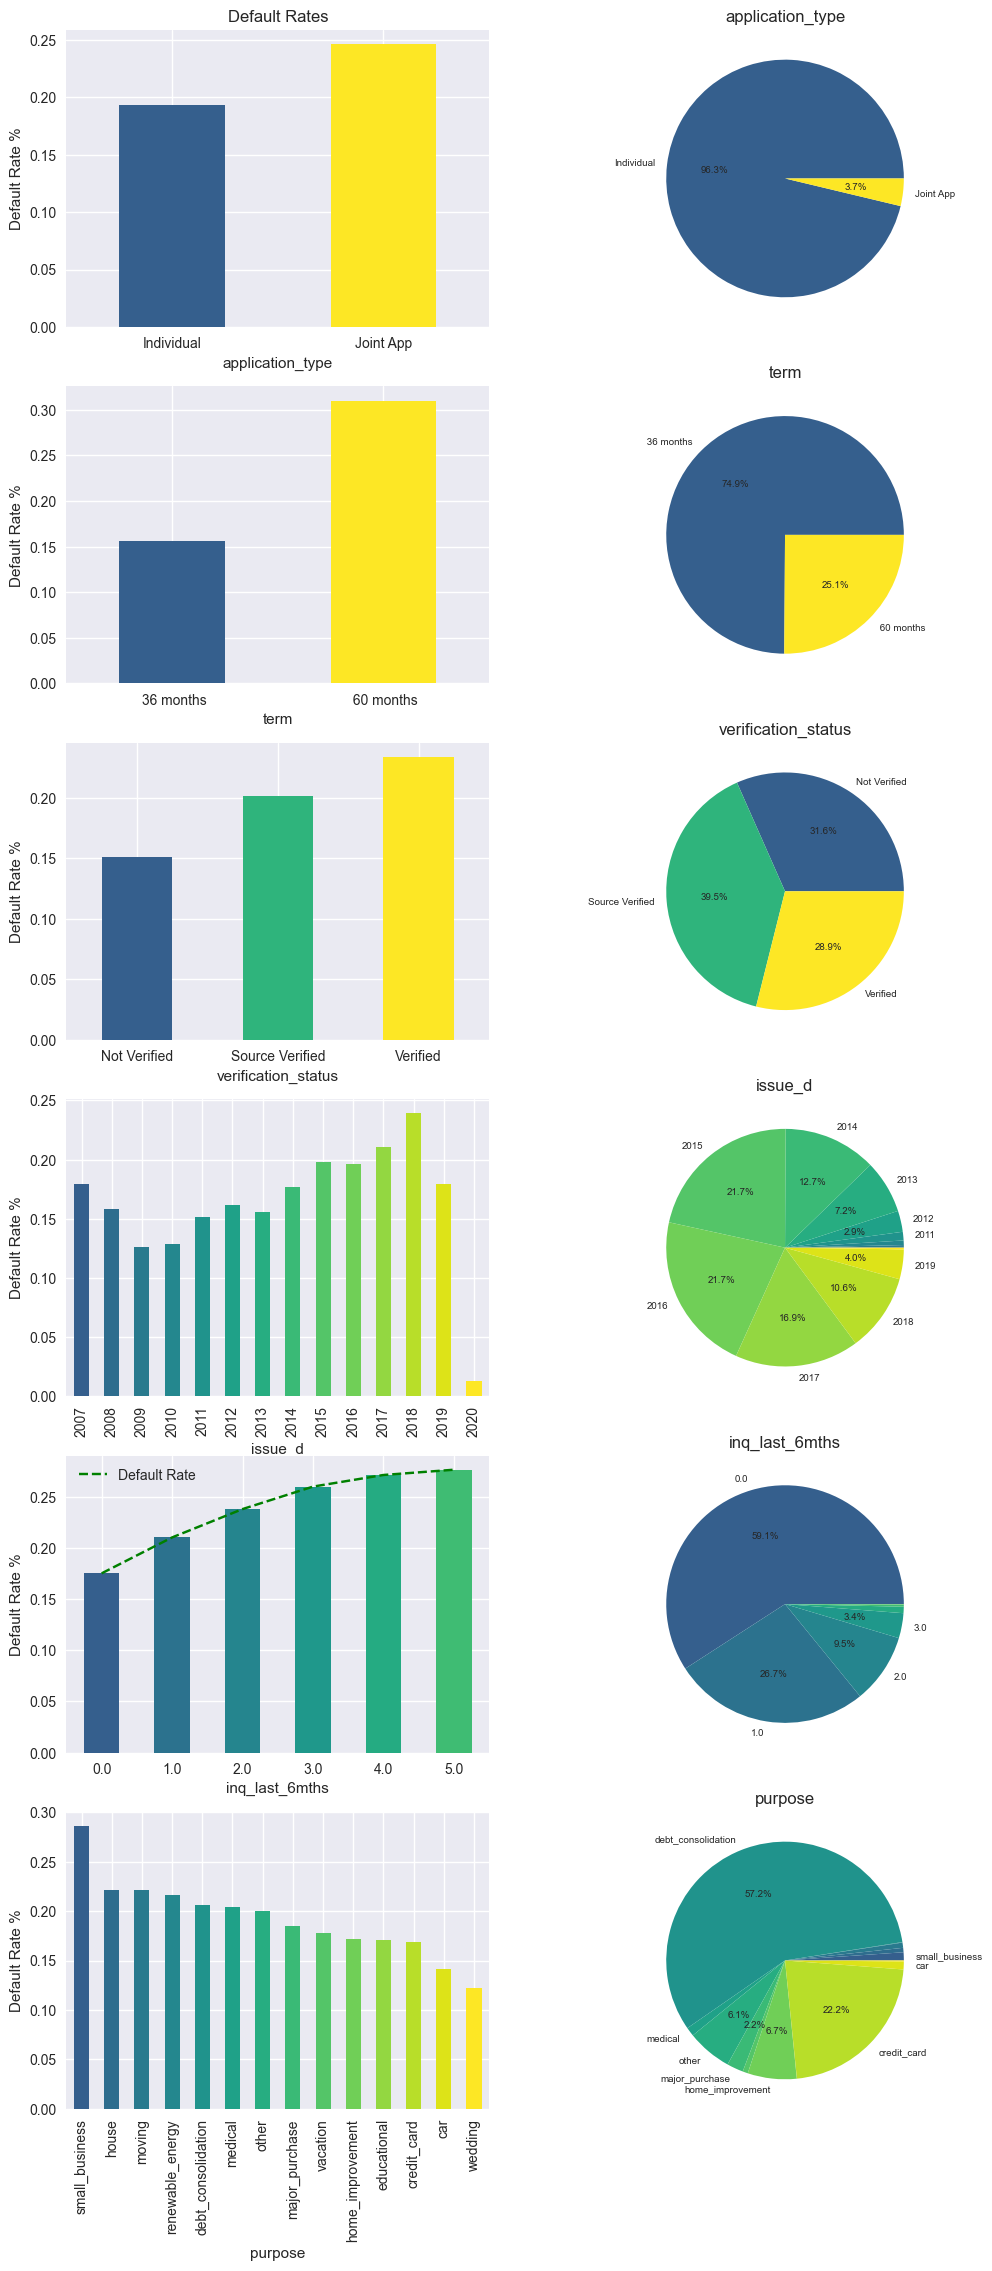

In [89]:
def analysis_on_application(data,styles=['pie','boxplot'], height=4.5):
    cols = ['application_type','term','verification_status','issue_d',  'inq_last_6mths','purpose']

    graph = Graph_Generator(styles=styles, rows=len(cols), height=height)
    graph.plot(data,cols=cols,sort=['purpose'])
    # small adjustment on inq_last_6mths
    table = graph.groupby_table(data, factor='inq_last_6mths')
    table = table.loc[table['Count']>1000]
    print (table)
    table.plot(y='Default Rate',ax=graph.ax[4,0], color='g', linestyle='dashed')
    graph.ax[4,0].set_xlim([-0.5, 5.5])
    return

logger.info('sample size:  %d  ,  %s'%(len(loans), 'Applicantion' ))
analysis_on_application(loans, styles=['bar','pie'])

#### Applicants Information :  Work history , home ownership, mortgage etc
- **Home ownership**: Approximately 50% of applicants possess a mortgage, and this group demonstrates the lowest default rate compared to other status such as "rent" and "own". Although the default rate is notably high for applicants with an "other" home ownership status, it's crucial to note that only <10 people chose this category in the 18000+ samples. The limited sample size restricts drawing definitive conclusions about this particular category.

- **Employment Length**: A third of borrowers have over 10 years of work experience while about 8% chose not to tell. Overall default rate decrease slightly as employment length increases. However it is a warning sign if applicants left it blank (null), groups with null have a much higher risk than those who filled in the employment length of 0 and 1. 

-  **Open accounts** : This term typically refers to the number of open credit accounts that an individual possesses. Generally, the default rate exhibits a gradual increase with a higher number of open credit accounts. However, it's noteworthy that the default rate is notably higher for individuals with fewer than five credit accounts initially, before following a trend of increasing slowly as the number of credit accounts rises.

-  **Annual Income** : The annual income is converted to log space with the maximum income 110M dollars and the minimum income 0. The average annual income of the fully paid individuals is higher than that of defaulted ones.

- **Earlist Credit Line**: According to Forbes, approximately 73% of Americans possess a credit card by the age of 25. Consequently, the earliest credit line can serve as an indicator of the applicant's age. The graph illustrating the default rate against the earliest credit year reveals a parabola-shaped curve, with the lowest default rate occurring around the years 1980 to 1990, corresponding to the baby boomer generation. Subsequently, the default rate demonstrates a steady increase post-1990, reaching its peak in the most recent years. This trend suggests a correlation between the earliest credit line and the likelihood of default.


INFO - - - - - - - - sample size:  1860331  ,  Applicantion  - - - - - - - 


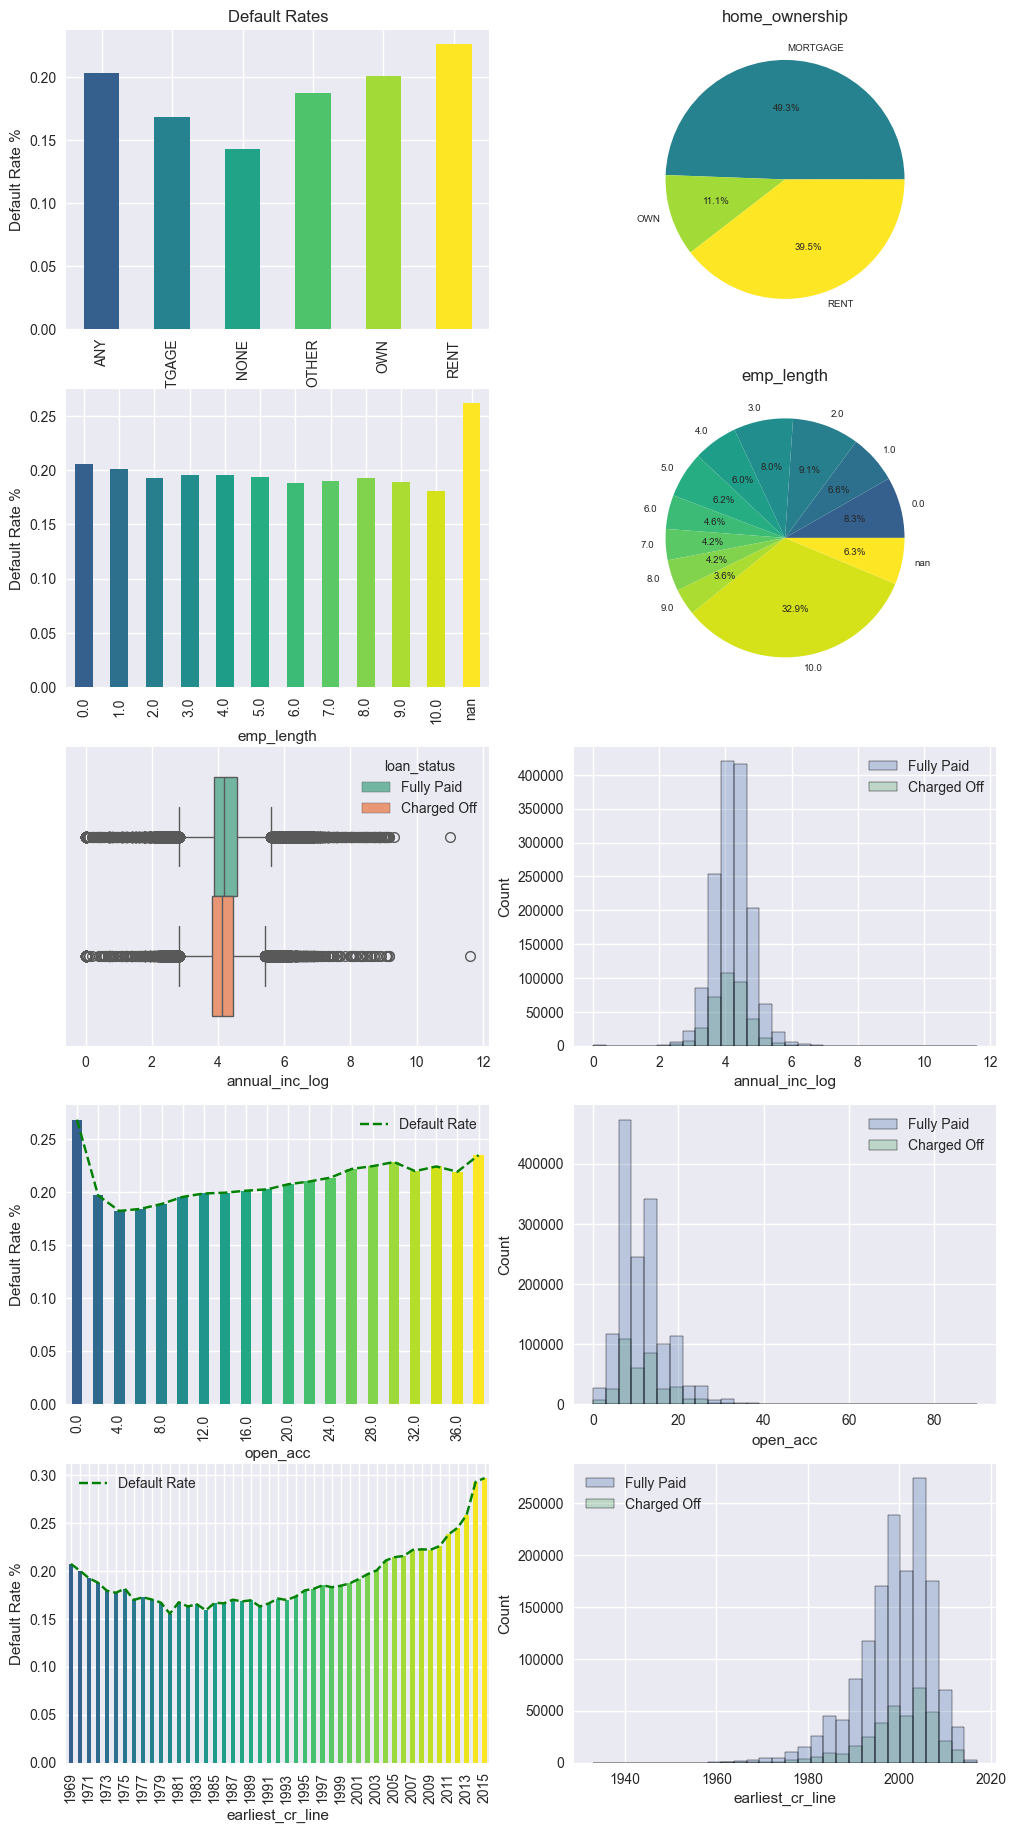

In [107]:
def analysis_on_borrower(data):
    df = data.copy()
    df['annual_inc_log'] =  np.log(df['annual_inc']/1e3+1) #+1 to avoid log zero problem
    df['open_acc'] = df['open_acc']//2*2
    cols1 = ['home_ownership','emp_length']
    cols2 = ['annual_inc_log']
    cols3 = ['open_acc','earliest_cr_line']

    graph = Graph_Generator(styles=['bar','pie'], rows=len(cols1+cols2+cols3))
    graph.plot(df,cols=cols1)
    graph.styles = ['boxplot','hist']
    graph.plot(df,cols=cols2, base=len(cols1))
    graph.styles = ['bar_with_line','hist']
    threshold = 0.0005*len(df)     # take 99.9% of data, 3 std away from mean.  
    graph.plot(df,cols=cols3, base=len(cols1)+len(cols2),threshold=threshold)
    return

logger.info('sample size:  %d  ,  %s'%(len(loans), 'Applicantion' ))
analysis_on_borrower(loans)

#### Applicants Information : Debt history
- **Number of delinquency within the last 2 years** There is a clear positive correlation between default rate and number of past-due accounts within 2 years  

- **Months since last past due** There is no significant difference in number of months since the last past due between borrowers who have been charged off and those who have fully paid off their loans.

- **Number of public records** Approximately 83% of applicants do not have any public records, while 14% have one record. It is not obvious to spot any relationship between number of public records and default rate, although it was found that applicants with public records are more likely to go default. 

- **Revolving line utilization rate** Refers to the ratio of the amount of credit being used to the total credit available on a revolving credit account, typically expressed as a percentage. The resolving line utilization rate is inversely correlated to default rate. Lower utilization rates are associated with lower default rates, indicating that individuals who use a smaller portion of their available credit are less likely to default on their payments. This is because lower utilization rates typically reflect responsible credit management and may signal to lenders that the borrower is less financially stressed. From the box plot of revolving balance against default rate, it's apparent that the ratio of credit utilization matters more than the total amount used.

INFO - - - - - - - - sample size:  1860331  ,  Debt history  - - - - - - - 


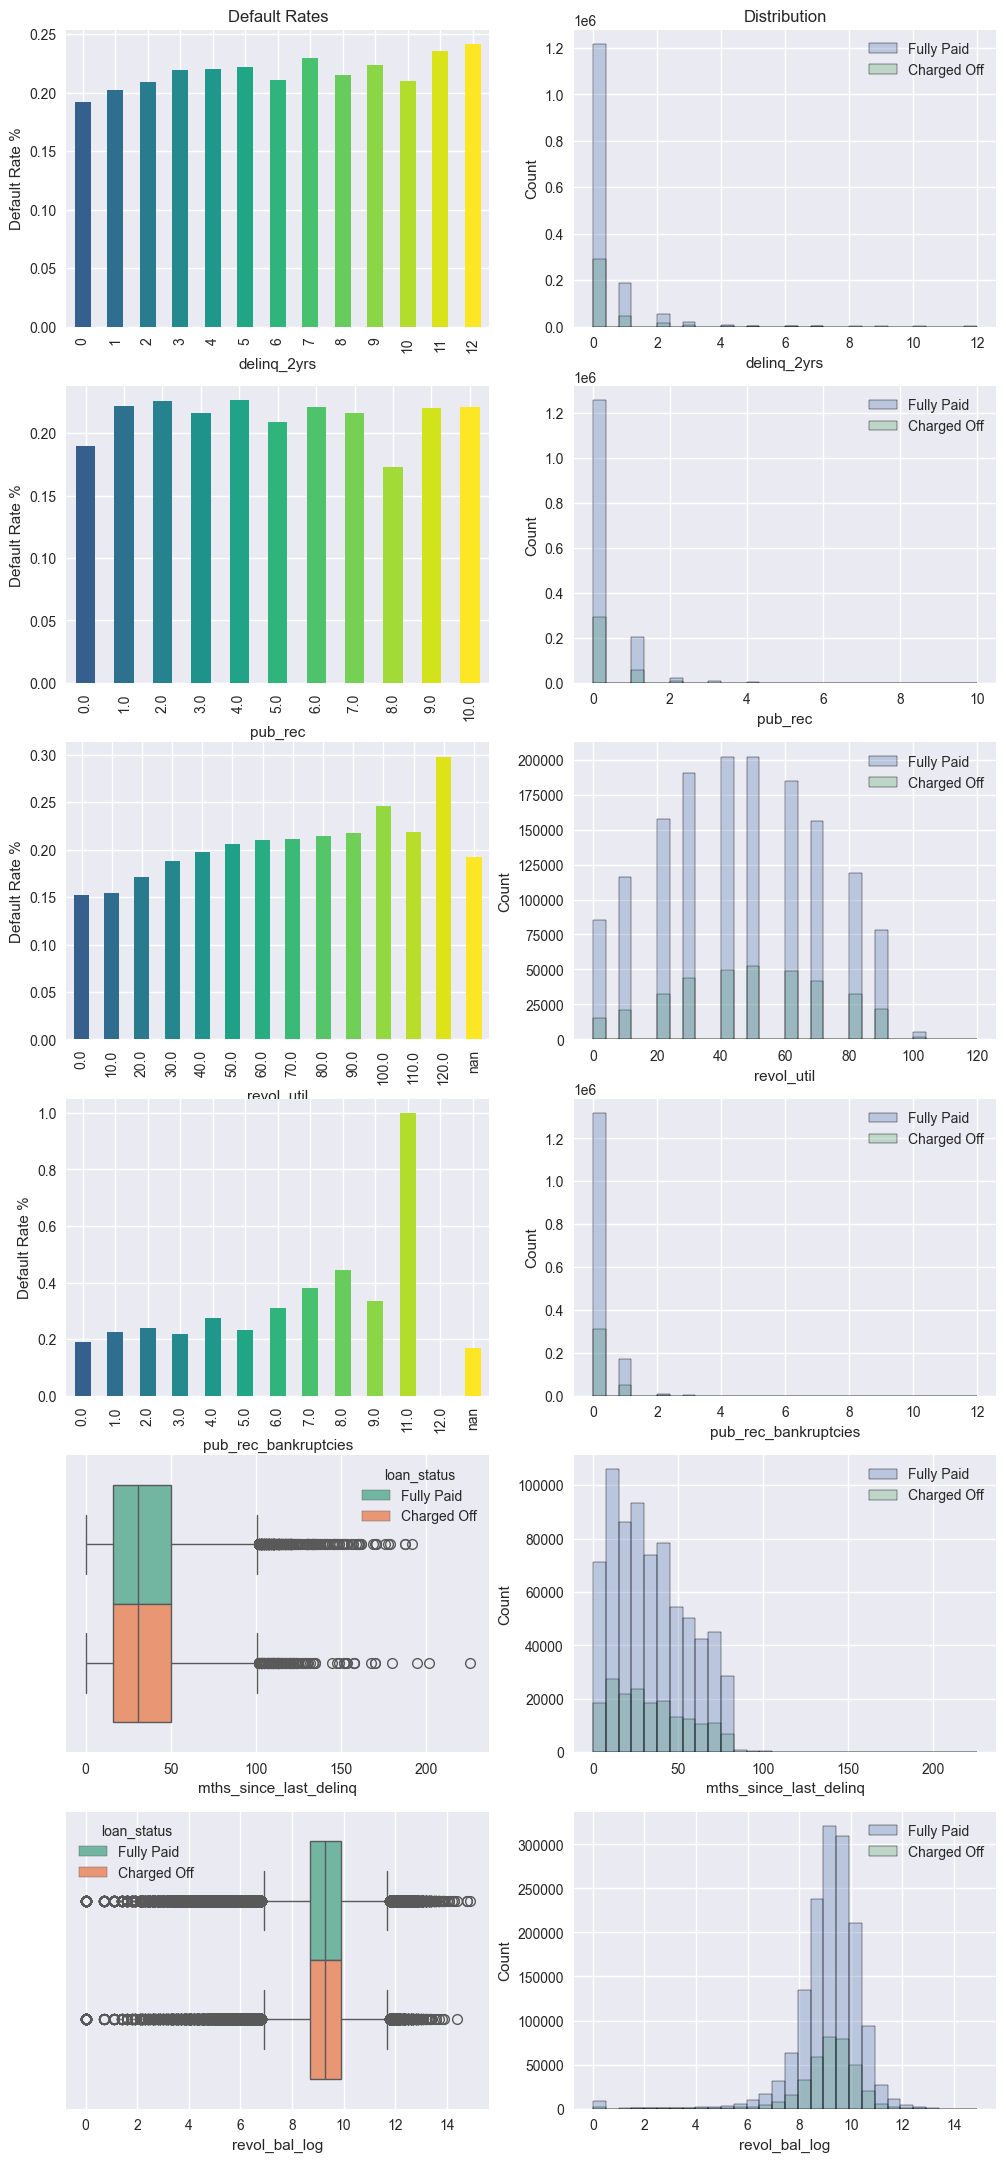

In [39]:
def analysis_on_debt_history(data):
    df = data.copy()  
    threshold = 0.001*len(df)     # take 99.9% of data, 3 std away from mean.
    cols1 = ['delinq_2yrs','pub_rec','revol_util','pub_rec_bankruptcies']
    cols2 = [ 'mths_since_last_delinq','revol_bal_log']
    
    df['delinq_2yrs'] = df['delinq_2yrs'].astype(int)
    df.loc[df['delinq_2yrs']>=12,'delinq_2yrs'] = 12  # 0-12 covers 99% of population
    df.loc[df['pub_rec']>=10,'pub_rec'] = 10
    df['revol_bal_log'] = np.log(df['revol_bal']+1).round(1)  
    df.loc[df['revol_util']>=120,'revol_util'] = 120
    df['revol_util'] = df['revol_util']//10*10
    graph = Graph_Generator(styles=['bar','hist'], rows=len(cols1+cols2))
    graph.plot(df,cols=cols1, debug=False)
    graph.styles = ['boxplot','hist']
    graph.plot(df,cols=cols2, base=len(cols1))
    return

logger.info('sample size:  %d  ,  %s'%(len(loans), 'Debt history' ))
analysis_on_debt_history(loans)

#### Address

In [ ]:
loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

### Modelling
#### Preprocessing 
- Categorical variables: Convert to dummy variables e.g 0 0 1 
- Fill NaN values:
    - fillna with -1:  In the data analysis section earlier, we found that people left employment length blank had a much higher rate of default than any other options. Therefore we assign a negative number here to distinguish with 0 years of employment history
    - fillna with mean:  Data type is continuous data, and only a small percent of values are NaN. e.g 'revol_util','dti','mort_acc','pub_rec_bankruptcies'
    - fillna with mode: Discrete data type. e.g 'inq_last_6mths',  'chargeoff_within_12_mths'
    - fillna with zero. A vast marjority is NaN. For example in months since last delinquency, NaN counts about 50% of the population. It makes more sense to fill NaN with zero instead of mean. 
- train-test split 
- modeling 
    - Logistic Regression 
    - Random Forest
    - Xgboost
- plot ROC-AUC graph
- grid search parameters for the models
- performance metrics



In [4]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn import metrics
# from sklearn.model_sele
# from imblearn.over_sampling import SMOTE 
from collections import Counter

In [7]:
def data_processing(data):
    df = data.copy()
    # convert some numerical columns to log scales
    df['annual_inc_log'] =  np.log(df['annual_inc']/1e3+1) #+1 to avoid log zero problem
    df['revol_bal_log'] = np.log(df['revol_bal']+1)
    
    # fill null values
    fill_mean = ['revol_util','dti',]
    fill_mode = ['inq_last_6mths','chargeoff_within_12_mths','pub_rec_bankruptcies','mort_acc']
    df[fill_mean] = df[fill_mean].fillna(df[fill_mean].mean())
    df[fill_mode] = df[fill_mode].fillna(df[fill_mode].mode().iloc[0])
#     print (df[fill_mode].mode().iloc[0])
    #create a new column emp_length_nan - from observation in EDA section, higher default if left nan 
    df['emp_length_nan'] = 0
    df.loc[df['emp_length'].isna(),'emp_length_nan']=1
#     print (df.loc[df['emp_length_nan']==1,['loan_status','emp_length','emp_length_nan']])
    df['mths_since_last_delinq'].fillna(0,inplace=True)
    df['emp_length'].fillna(0,inplace=True)
    
    df = df.drop(columns=['index','id','grade','title','annual_inc','revol_bal'])
    df = pd.get_dummies(df, columns=['sub_grade', 'term', 'home_ownership', 'verification_status', 
                                     'purpose', 'addr_state', 'initial_list_status',
                                     'application_type'], drop_first=True)
    y = df[['loan_status']].replace({'Fully Paid': 1, 'Charged Off':0})
    X = df.loc[:, df.columns != 'loan_status']*1
    # train:test:val = 3:1:1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    # rescale 
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    return (X_train, X_test, X_val, y_train.values.ravel(), y_test.values.ravel(), y_val.values.ravel())

X_train, X_test, X_val, y_train, y_test, y_val = data_processing(loans)
# X_train.isna().any()

NameError: name 'scaler' is not defined

#### Logistic Regression
- Pros: Simple, interpretable, fast to train, works well with binary classification tasks.
- Cons: Assumes linear relationship between features and target variable, may underperform if the data is highly non-linear.
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200522215734/download35.jpg">





In [6]:
def plot_ROC_curve(model):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)
    
    fpr, tpr, _ = metrics.roc_curve(y_val, y_pred_proba[:, 1])
    auc = metrics.roc_auc_score(y_val, y_pred_proba[:, 1])
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc.round(3)))
    plt.legend(loc=4)
    plt.title('ROC AUC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
plot_ROC_curve(linear_model.LogisticRegression(max_iter=3000, n_jobs=4,class_weight="balanced"))

KeyboardInterrupt: 

In [ ]:
X_train.shapes

In [49]:
def model_performance(model, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    precision,recall,f1,_ = precision_recall_fscore_support(y_train, y_pred,average='binary')
    print ('logistic ',round(precision,3), round(recall,3), round(f1,3))

def grid_search_models():
    mymodels = [{"name": "Logistic Regression",
             "model": linear_model.LogisticRegression(max_iter = 3000, n_jobs=4, class_weight="balanced"),
             "param": {"solver":["newton-cg","lbfgs","saga"],
                       "penalty":["l1", "l2", "elasticnet"],
                       "C": :np.logspace(-3,3,7)
                      }
                },
                 {"name":'Random Forest',
                 "model":RandomForestClassifier(class_weight="balanced"),
                 "param":{"n_estimators": [10, 20,50, 100],
                           "criterion": ["entropy", "gini","log_loss"],
                           "max_depth": [2, 5, 10],
                           "max_features": ["log2", "sqrt"],
                           "min_samples_split": [2, 3, 5], 
                         }
                 },
#                  {"name":'',
#                  "model":'',
#                  "param":{}
#                  }
              
             ]
    for item in mymodels:
        print (item['name'])
        grid = GridSearchCV(item['model'], item['param'], cv=5, scoring='precision',n_jobs=-1, )
        grid.fit(X_train[0:50000], y_train[0:50000])
        print ('-+'*10)
        y_pred = grid.predict(X_val)

        print(item['name'], ' best score: ', grid.best_score_)
        print(grid.best_params_)
#         model  = linear_model.LogisticRegression(max_iter = 5000, n_jobs=4)
#         model.fit(X_train, y_train.values.ravel())
#         y_pred = model.predict(X_test)
#         print("Accuracy", metrics.accuracy_score(y_test, y_pred))
#         #AUC Curve
#         y_pred_proba = model.predict_proba(X_test)[::,1]
#         fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
#         auc = metrics.roc_auc_score(y_test, y_pred_proba)
#         plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
#         plt.legend(loc=4)
#         plt.show()


grid_search_models( )
# X_train[X_train.isnull().any(axis=0)]
# [X_train.isna(how='any')]
# X_train.isna().any()

Logistic Regression


/Users/mumuxi/Desktop/Projects/git/env/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mumuxi/Desktop/Projects/git/env/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mumuxi/Desktop/Projects/git/env/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mumuxi/Desktop/Projects/git/env/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mumuxi/Desktop/Projects/git/env/lib/python3.1

/Users/mumuxi/Desktop/Projects/git/env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.86464627 0.89062746 0.87713891 0.8646411
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(
/Users/mumuxi/Desktop/Projects/git/env/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mumuxi/Desktop/Projects/git/env/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/mumuxi/Desktop/Projects/git/env/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors pr

-+-+-+-+-+-+-+-+-+-+
0.8906274588377883
{'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
Random Forest
-+-+-+-+-+-+-+-+-+-+
0.8915082444233775
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 50}


In [ ]:
#### 4.2 Standardlized the train data and fit scaler to test dataset
0.8067857399038807 0.9992958888348404 0.8927809908786302

In [ ]:
def standardlize(train,test,X):
    scaler = preprocessing.StandardScaler()
    sc_train = scaler.fit_transform(train[col])
    sc_test  = scaler.transform(test[col])
    sc_X     = scaler.transform(X[col])
    train = pd.concat([pd.DataFrame(sc_train, columns=col),train.iloc[:,3::].reset_index(drop=True)],axis=1)
    test = pd.concat([pd.DataFrame(sc_test, columns=col),test.iloc[:,3::].reset_index(drop=True)],axis=1)
    X = pd.concat([pd.DataFrame(sc_X, columns=col),X.iloc[:,3::].reset_index(drop=True)],axis=1)
    return train, test, X

def min_max_scaler(df):
    scaler = preprocessing.MinMaxScaler()
    scaled_df = scaler.fit_transform(df)
    df = pd.DataFrame(scaled_df, columns=df.columns)
    return df

x_train,x_test,X = standardlize(x_train,x_test,X)

reference: https://cs229.stanford.edu/proj2018/report/69.pdf  
Helper Function - drawing functions

In [ ]:
class Graph_Generator:
    def __init__(self, styles, rows, height=4.5):
        self.styles = styles
        self.colormap = plt.colormaps["viridis"] 
        self.fig, self.ax = plt.subplots(nrows=rows, ncols=2,  figsize=(12, rows*height),squeeze=True)
        
    def cmap(self, N):
        return self.colormap(np.linspace(0.3, 1, N))
        
    def pie_chart(self, data, i, j):
        data['Count pct'] = 100*data['Count']/data['Count'].sum()
        if len(data)>5:
            data['Label'] = data.apply(lambda x: x.name if x['Count pct'] >1 else ' ', axis=1)
        data.plot(
            kind='pie', 
            y   ='Count',
            autopct=lambda v: f'{v:.1f}%' if v>2 else '', 
            labels=data['Label'],
            legend=False,
            ax=self.ax[i,j],
            colors=self.cmap(len(data)),
            fontsize=7)
        self.ax[i,j].set_ylabel('')
        self.ax[i,j].set_title(data.index.name)
    
    def bar_chart_with_line(self, data, i, j, threshold=0):
        table = data.loc[data['Count']>threshold] # take 99.9% of data, 3 std away from mean. 
        table.index = table.index.astype('str')
        table.plot(y='Default Rate',ax = self.ax[i,j], color='g', linestyle='dashed')
        self.bar_chart(table,i,j)        
        
    def bar_chart(self, data, i, j ):
        rotation = 90 if len(data)>5 else 0
        data.plot.bar(y='Default Rate',
                             color=self.cmap(len(data)),
                             legend=False,
                             ax = self.ax[i,j],
                             rot=rotation
                            )
        if len(data)>15:
            step = max(len(data)//20,2)
            self.ax[i,j].set_xticklabels([v if k%step==0 else ' ' for k,v in enumerate(data['Label'])])
        self.ax[i,j].set_ylabel('Default Rate %')
        
    def hist_chart(self,data, factor, i, j):
        sns.histplot(data=data, x=factor,hue='loan_status', bins=30, ax=self.ax[i, j],  alpha=0.3)
        self.ax[i,j].legend_.set_title(None)
    def box_chart(self,data,factor,i,j):
        sns.boxplot(data=data, x=factor,hue='loan_status', orient="h", palette="Set2",ax=self.ax[i,j])
    def set_ax_title(self):
        title_name = {
            'bar':'Default Rates',
            'hist': 'Distribution',
            'boxplot': 'Boxplot',
            'bar_with_line': 'Bar Plot'
        }
            
        self.ax[0,0].set_title(title_name[self.styles[0]])
        if self.styles[1] in ['bar', 'hist','boxplot']:
            self.ax[0,1].set_title(title_name[self.styles[1]])
        
    def update_ax_param(self,i, j, title=None, ylabel=None, xlabel=None):
        if title:
            self.ax[i,j].set_title(title)
        if ylabel:
            self.ax[i,j].set_ylabel(ylabel)
        if xlabel:
            self.ax[i,j].set_xlabel(xlabel)
            
    @staticmethod
    def groupby_table(df, factor):
        table = df[[factor,'loan_status']].groupby('loan_status'
                                                       ).value_counts(dropna=False
                                                       ).unstack(fill_value=0).T
        table['Count']        = table['Fully Paid'] + table['Charged Off']
        table['Default Rate'] = table['Charged Off']/table['Count']
        table['Label'] = table.index.astype(str)
        return table 
    
    def plot(self,df, cols, debug=False, sort=[], sort_by='Default Rate', threshold=0, base=0):
        for idx, factor in enumerate(cols):
            table = self.groupby_table(df,factor)
            table = table.loc[table['Count']>threshold]
            if factor in sort:
                table = table.sort_values(by=sort_by, ascending=False)   #sort
            if debug:
                display(table)
            for j, style in enumerate(self.styles):
                if style =='pie':
                    self.pie_chart(data=table, i=base+idx , j=j)
                elif style =='boxplot':
                    self.box_chart(data=df, factor=factor, i=base+idx, j=j)
                elif style =='bar':
                    self.bar_chart(data=table, i=base+idx , j=j)
                elif style =='bar_with_line':
                    self.bar_chart_with_line(data=table,i=base+idx, j=j)
                elif style =='hist':
                    self.hist_chart(data=df, factor=factor, i=base+idx, j=j)
        if base == 0:
            self.set_ax_title()
    
    

In [12]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
        
def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

📏 Normalizing the data
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status
X_train.dtypes
loan_amnt         float64
term                int64
int_rate          float64
installment       float64
annual_inc        float64
                   ...   
zip_code_30723      uint8
zip_code_48052      uint8
zip_code_70466      uint8
zip_code_86630      uint8
zip_code_93700      uint8
Length: 78, dtype: object
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
🤖 Models Building
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)
✔️ Artificial Neural Networks (ANNs)
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)
plot_learning_evolution(r)

y_train_pred = model.predict(X_train)
evaluate_nn(y_train, y_train_pred.round(), train=True)
Train Result:
================================================
Accuracy Score: 88.84%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.95      0.88      0.89       0.92          0.90
recall        0.46      0.99      0.89       0.73          0.89
f1-score      0.62      0.93      0.89       0.78          0.87
support   51665.00 210478.00      0.89  262143.00     262143.00
_______________________________________________
Confusion Matrix: 
 [[ 23680  27985]
 [  1281 209197]]

y_test_pred = model.predict(X_test)
evaluate_nn(y_test, y_test_pred.round(), train=False)
Test Result:
================================================
Accuracy Score: 88.87%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.94      0.88      0.89       0.91          0.89
recall        0.46      0.99      0.89       0.73          0.89
f1-score      0.62      0.93      0.89       0.78          0.87
support   25480.00 104943.00      0.89  130423.00     130423.00
_______________________________________________
Confusion Matrix: 
 [[ 11682  13798]
 [   724 104219]]

scores_dict = {
    'ANNs': {
        'Train': roc_auc_score(y_train, model.predict(X_train)),
        'Test': roc_auc_score(y_test, model.predict(X_test)),
    },
}
✔️ XGBoost Classifier
# param_grid = dict(
#     n_estimators=stats.randint(10, 500),
#     max_depth=stats.randint(1, 10),
#     learning_rate=stats.uniform(0, 1)
# )

xgb_clf = XGBClassifier(use_label_encoder=False)
# xgb_cv = RandomizedSearchCV(
#     xgb_clf, param_grid, cv=3, n_iter=60, 
#     scoring='roc_auc', n_jobs=-1, verbose=1
# )
# xgb_cv.fit(X_train, y_train)

# best_params = xgb_cv.best_params_
# best_params['tree_method'] = 'gpu_hist'
# # best_params = {'n_estimators': 50, 'tree_method': 'gpu_hist'}
# print(f"Best Parameters: {best_params}")

# xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)
Train Result:
================================================
Accuracy Score: 89.60%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.95      0.89      0.90       0.92          0.90
recall        0.50      0.99      0.90       0.75          0.90
f1-score      0.65      0.94      0.90       0.80          0.88
support   51665.00 210478.00      0.90  262143.00     262143.00
_______________________________________________
Confusion Matrix: 
 [[ 25828  25837]
 [  1423 209055]]

Test Result:
================================================
Accuracy Score: 88.94%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.91      0.89      0.89       0.90          0.89
recall        0.48      0.99      0.89       0.73          0.89
f1-score      0.63      0.94      0.89       0.78          0.88
support   25480.00 104943.00      0.89  130423.00     130423.00
_______________________________________________
Confusion Matrix: 
 [[ 12212  13268]
 [  1159 103784]]

disp = ConfusionMatrixDisplay.from_estimator(
    xgb_clf, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)


scores_dict['XGBoost'] = {
        'Train': roc_auc_score(y_train, xgb_clf.predict(X_train)),
        'Test': roc_auc_score(y_test, xgb_clf.predict(X_test)),
    }
✔️ Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators=100)
# 
rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)
Train Result:
================================================
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     1.00      1.00      1.00       1.00          1.00
recall        1.00      1.00      1.00       1.00          1.00
f1-score      1.00      1.00      1.00       1.00          1.00
support   51665.00 210478.00      1.00  262143.00     262143.00
_______________________________________________
Confusion Matrix: 
 [[ 51665      0]
 [     0 210478]]

Test Result:
================================================
Accuracy Score: 88.94%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.96      0.88      0.89       0.92          0.90
recall        0.46      0.99      0.89       0.72          0.89
f1-score      0.62      0.94      0.89       0.78          0.87
support   25480.00 104943.00      0.89  130423.00     130423.00
_______________________________________________
Confusion Matrix: 
 [[ 11594  13886]
 [   542 104401]]

disp = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['Default', 'Fully-Paid'])

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, ax=disp.ax_)
<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7f1bd1947d50>


scores_dict['Random Forest'] = {
        'Train': roc_auc_score(y_train, rf_clf.predict(X_train)),
        'Test': roc_auc_score(y_test, rf_clf.predict(X_test)),
    }
📊 Comparing Models Prerformance
RANDOM FOREST                  roc_auc_score: 0.725
XGBOOST                        roc_auc_score: 0.734
ANNS                           roc_auc_score: 0.905
 
        

Cross-validation scores: [1.         0.93333333 1.         0.93333333 0.93333333 0.93333333
 0.86666667 1.         1.         1.        ]
